In [19]:
import sys
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.datasets import make_classification, make_regression
from scipy.stats import spearmanr

# import the path of the project
sys.path.append(os.path.abspath("src"))

from preprocess.FeatureSplitter import CorrelationSplitter, ImportanceSplitter
from preprocess.FeatureEvaluator import CorrelationEvaluator, ImportanceEvaluator

#auto reload modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
# Summarize a correlation matrix calculated between two parties (X_i and X_j)
# The shape of corr is (X_i.shape[1], X_j.shape[1])

def pcor_eigen(corr):
    """Summarize the correlation matrix corr"""
    assert corr.shape[0] == corr.shape[1]   # eigenvalues are only defined for square matrices
    eigen_values = np.linalg.eigvals(corr)
    score = np.std(eigen_values)
    return score

def pcor_singular(corr):
    """Summarize the correlation matrix corr"""
    singular_values = np.linalg.svd(corr)[1]
    score = np.std(singular_values)
    return score

print(pcor_eigen(np.ones((10, 10))))
print(pcor_eigen(np.eye(10)))
print(pcor_singular(np.ones((10, 10))))
print(pcor_singular(np.eye(10)))

3.0
0.0
2.999999999999999
0.0


In [35]:
# Generate two binary classification datasets with correlated features and a target
def test_correlation_by_moving_features(n_informative, n_features1, n_features2, pcor_func, save_path=None, label='Pcor'):

    # set a larger font size for plots
    plt.rcParams.update({'font.size': 16})

    assert n_features1 <= n_features2
    assert n_informative <= n_features1 and n_informative <= n_features2
    n_features_on_party = [n_features1, n_features2]
    n_features = n_features1 + n_features2
    X1, y1 = make_classification(n_samples=10000, n_features=n_features1, n_informative=n_informative,
                                 n_redundant=n_features1 - n_informative,
                                 n_repeated=0, n_classes=2, random_state=0, shuffle=True)
    X2, y2 = make_classification(n_samples=10000, n_features=n_features2, n_informative=n_informative,
                                 n_redundant=n_features2 - n_informative,
                                 n_repeated=0, n_classes=2, random_state=1, shuffle=True)
    X = np.concatenate([X1, X2], axis=1)
    corr = spearmanr(X).correlation

    X1_ids = np.arange(n_features)[:n_features1]
    X2_ids = np.arange(n_features)[n_features1:]
    n_X1s = np.arange(n_features1 + 1)
    pcor1s = []
    pcor2s = []
    pcor12s = []
    for n_X1 in n_X1s:
        assert n_X1 <= n_features1
        X1_ids_1 = X1_ids[:n_X1]
        X2_ids_1 = X2_ids[:n_features1-n_X1]
        ids_1 = np.concatenate([X1_ids_1, X2_ids_1])
        X1_ids_2 = X1_ids[n_X1:]
        X2_ids_2 = X2_ids[n_features1-n_X1:]
        ids_2 = np.concatenate([X1_ids_2, X2_ids_2])

        corr1 = corr[ids_1, :][:, ids_1]
        corr2 = corr[ids_2, :][:, ids_2]
        corr_12 = corr[ids_1, :][:, ids_2]

        # initialize a new correlation matrix with an identity matrix
        corr_masked = np.zeros(corr.shape)
        corr_masked[np.ix_(ids_1, ids_2)] = corr[np.ix_(ids_1, ids_2)]
        corr_masked[np.ix_(ids_1, ids_2)] = corr[np.ix_(ids_1, ids_2)]

        pcor1 = pcor_func(corr1)
        pcor2 = pcor_func(corr2)
        pcor12 = pcor_func(corr_12)
        # print(f"n_X1: {n_X1}, pcor1: {pcor1:.4f}, pcor2: {pcor2:.4f}, pcor12: {pcor12:.8f}")
        pcor1s.append(pcor1)
        pcor2s.append(pcor2)
        pcor12s.append(pcor12)


    # plot the trend of pcor1, pcor2, and pcor12 w.r.t. n_X1
    ax = plt.gca()
    ax.invert_xaxis()
    fig = plt.gcf()
    plt.xlabel("Party $P_1$: number of features from $X_1$")
    plt.ylabel(f"Correlation Index ({label})")
    ax.plot(n_X1s, pcor1s, label=f"{label}1-1", marker="o")
    ax.plot(n_X1s, pcor2s, label=f"{label}2-2", marker="^")
    ax.plot(n_X1s, pcor12s, label=f"{label}1-2", marker="x")
    # add an x-axis to show the number of informative features from X2

    ax2 = ax.twiny()
    ax2.set_xlim(ax.get_xlim())
    ax.set_xticks(n_X1s)
    ax.set_xticklabels(n_X1s)
    ax2.set_xticks(n_X1s)
    ax2.set_xticklabels(n_features1 - n_X1s)
    ax2.set_xlabel("Party $P_2$: number of features from $X_1$")

    # plt.title(f"(Party 1: {n_features1} features, Party 2: {n_features2} features)\n(X1: {n_features1} features, X2: {n_features2} features)")

    ax.legend()
    plt.show()

    if save_path is not None:
        fig.savefig(save_path)
    plt.close()


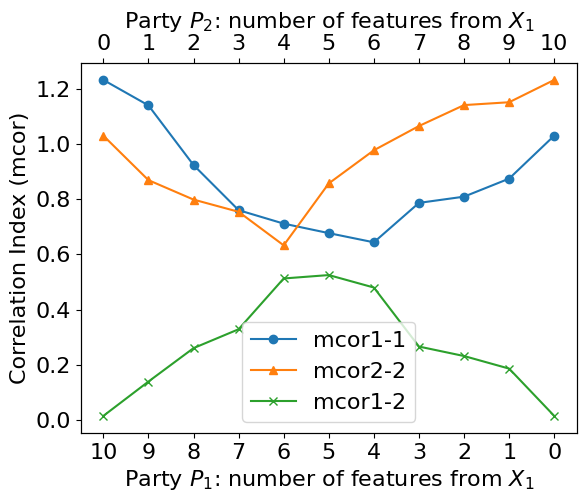

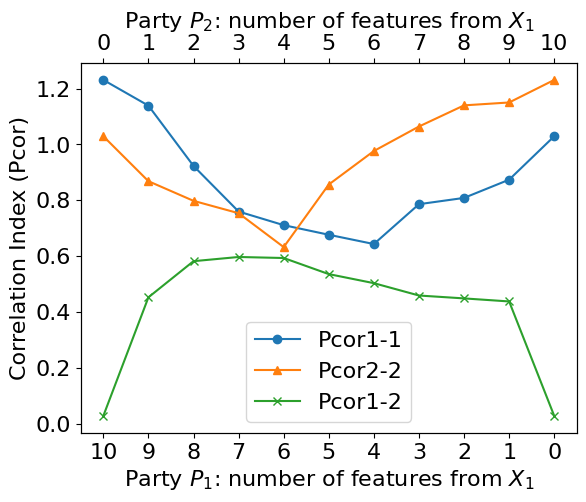

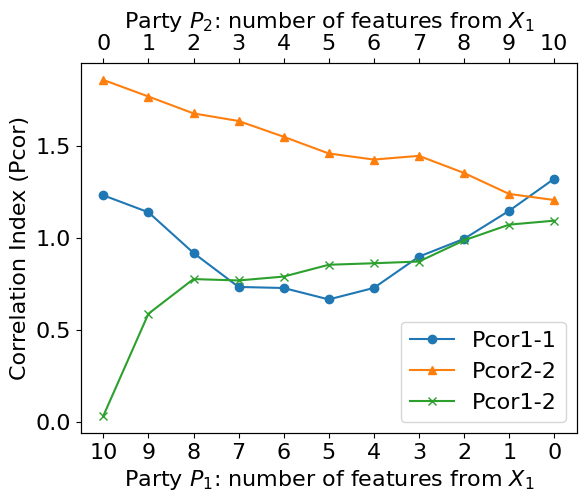

In [37]:
# test two functions
test_correlation_by_moving_features(n_informative=6, n_features1=10, n_features2=10, pcor_func=pcor_eigen,
                                    save_path="fig/pcor-eigen-10-10.png", label='mcor')
test_correlation_by_moving_features(n_informative=6, n_features1=10, n_features2=10, pcor_func=pcor_singular,
                                    save_path="fig/pcor-singular-10-10.png")
test_correlation_by_moving_features(n_informative=6, n_features1=10, n_features2=20, pcor_func=pcor_singular,
                                    save_path="fig/pcor-singular-10-20.png")

In [26]:
# generate three independent datasets
X1 = make_classification(n_samples=10000, n_features=10, n_informative=3, n_redundant=7, random_state=0, shuffle=True)[0]
X2 = make_classification(n_samples=10000, n_features=10, n_informative=3, n_redundant=7, random_state=1, shuffle=True)[0]
X3 = make_classification(n_samples=10000, n_features=10, n_informative=3, n_redundant=7, random_state=2, shuffle=True)[0]

# concatenate them to a global dataset
X = np.concatenate([X1, X2, X3], axis=1)
np.random.shuffle(X.T)

# original three parties
corr_evaluator_original = CorrelationEvaluator(gpu_id=0)
score_original = corr_evaluator_original.fit_evaluate([X1, X2, X3])
corr_evaluator_original.visualize("fig/pcor-original.png", value=score_original)

# fit the correlation splitter to get the lowest and highest correlation scores
corr_splitter = CorrelationSplitter(num_parties=3, evaluator=CorrelationEvaluator(gpu_id=0), gpu_id=0)
corr_splitter.fit(X, n_elites=200, n_offsprings=700, n_mutants=100, verbose=True)


CorrelationEvaluator uses cuda:0
Correlation calculation time: 0.03s
CorrelationEvaluator uses cuda:0
Calculating the min mcor of the overall correlation score...
n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |     1000 |  0.8094769997 |  0.7348143458
     2 |     1800 |  0.8019562121 |  0.7081426382
     3 |     2600 |  0.7971003982 |  0.7081426382
     4 |     3400 |  0.7968741019 |  0.6834173203
     5 |     4200 |  0.7950092761 |  0.6765739024
     6 |     5000 |  0.7928937828 |  0.6765739024
     7 |     5800 |  0.7918364580 |  0.6765739024
     8 |     6600 |  0.7898010842 |  0.6765739024
     9 |     7400 |  0.7885040436 |  0.6221222083
    10 |     8200 |  0.7872393962 |  0.6179156800
    11 |     9000 |  0.7855027169 |  0.6179156800
    12 |     9800 |  0.7853230850 |  0.6179156800
    13 |    10600 |  0.7814802435 |  0.6179156800
    14 |    11400 |  0.7804818783 |  0.6179156800
    15 |    12200 |  0.7790039512 |  0.5882597466
    16 |    13000 |  0.7768721824 |  

In [27]:
# split the correlation matrix with different beta
Xs_00 = corr_splitter.split(X, beta=0.0, n_elites=200, n_offsprings=700, n_mutants=100, verbose=True)
corr_evaluator_00 = CorrelationEvaluator(gpu_id=0)
score_00 = corr_evaluator_00.fit_evaluate(Xs_00)
corr_evaluator_00.visualize("fig/pcor-split-beta0.0.png", value=score_00, fontsize=28)

Xs_05 = corr_splitter.split(X, beta=0.5, n_elites=200, n_offsprings=700, n_mutants=100, verbose=True)
corr_evaluator_05 = CorrelationEvaluator(gpu_id=0)
score_05 = corr_evaluator_05.fit_evaluate(Xs_05)
corr_evaluator_05.visualize("fig/pcor-split-beta0.5.png", value=score_05, fontsize=28)

X_10 = corr_splitter.split(X, beta=1.0, n_elites=200, n_offsprings=700, n_mutants=100, verbose=True)
corr_evaluator_10 = CorrelationEvaluator(gpu_id=0)
score_10 = corr_evaluator_10.fit_evaluate(X_10)
corr_evaluator_10.visualize("fig/pcor-split-beta1.0.png", value=score_10, fontsize=28)

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |     1000 |  0.7767228214 |  0.6806237424
     2 |     1800 |  0.7679596693 |  0.6806237424
     3 |     2600 |  0.7643292229 |  0.6485753184
     4 |     3400 |  0.7635121106 |  0.6485753184
     5 |     4200 |  0.7602736262 |  0.6485753184
     6 |     5000 |  0.7588425980 |  0.6485753184
     7 |     5800 |  0.7582783826 |  0.6485753184
     8 |     6600 |  0.7561867962 |  0.6402281746
     9 |     7400 |  0.7525851977 |  0.6402281746
    10 |     8200 |  0.7506494522 |  0.6366805757
    11 |     9000 |  0.7494127356 |  0.6056104824
    12 |     9800 |  0.7471773719 |  0.5961941754
    13 |    10600 |  0.7416076899 |  0.5264275695
    14 |    11400 |  0.7371783958 |  0.5264275695
    15 |    12200 |  0.7316584721 |  0.4754698202
    16 |    13000 |  0.7250294456 |  0.4754698202
    17 |    13800 |  0.7151888357 |  0.4754698202
    18 |    14600 |  0.6997284828 |  0.3332143078
    19 |    15400 |  0.6882489218 |  0.2904579081


In [24]:
# correlation score of randomly shuffled the features
X_shuffle = X.copy()
np.random.shuffle(X_shuffle.T)
Xs_shuffle = np.split(X_shuffle, 3, axis=1)
corr_evaluator_shuffle = CorrelationEvaluator(gpu_id=0)
score_shuffle = corr_evaluator_shuffle.fit_evaluate(Xs_shuffle)
corr_evaluator_shuffle.visualize("fig/pcor-shuffle.png", value=score_shuffle, fontsize=28)

CorrelationEvaluator uses cuda:0
Correlation calculation time: 0.03s
